## Homework 5 - Explore Wikipedia's hyperlinks network

### Authors
* Michelangelo Saveriano
* Flavia Penta De Peppo
* Adrienn Timea Aszalos
* Nicola Calabrese

## Useful libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
import numpy as np
from collections import deque

For this homework we decide to implement from zero our class **HMGraph** instead of using the Python library networkx, in order to understand better the property and algorithm and the of ***Graph Teory***.


# HWGraph class

In [2]:
class HWGraph:
    def __init__(self, edge_df, category_df=None, names_df=None):
        nodes = pd.concat([edge_df.Source, edge_df.Target]).unique()

        # Find the neighbour for each node
        self.neighbors = dict()
        for node in nodes:
            self.neighbors[node] = []
        for s, t in edge_df.values:
            self.neighbors[s].append(t)

        # Create the edges dataframe
        self.edges = edge_df

        # Create the nodes dataframe
        self.nodes = pd.DataFrame.from_dict(data={'Node': self.neighbors.keys(),
                                                  'Neighbour': self.neighbors.values()}).set_index('Node')
        self.nodes = self.nodes.join(self.in_degree(False, False)).join(self.out_degree(False, False),
                                                                        lsuffix='In', rsuffix='Out').fillna(0)

        if category_df is not None:
            self.set_category(category_df)

        if names_df is not None:
            self.set_names(names_df)

        # Calculate the number of nodes and the number of edges
        self.n_nodes = len(self.nodes)
        self.n_edges = len(self.edges)

    def set_category(self, category_df):
        # Assign the node's category
        self.nodes = self.nodes.join(category_df.Category)

    def set_names(self, names_df):
        # Assign the node's label
        self.nodes = self.nodes.join(names_df.Names)

    def is_directed(self):
        # If the number of sources is different from the number of targets the graph is directed
        n_source, n_target = self.edges.nunique()
        if n_source != n_target:
            return True

        edge_list = self.edges.values.tolist()
        # For each edge (s,t) if the opposite edge (t,s) is not in the graph then the graph is directed
        for s, t in edge_list:
            if [t, s] not in edge_list:
                return True
        # Otherwise the graph is not directed
        return False

    def out_degree(self, average_degree=True, centrality=True):
        if average_degree:
            # If average degree is true the function returns the average out degree in the graph
            return self.edges.groupby('Source').size().sum() / self.n_nodes
        else:
            # Calculates the out degree for each node
            out_degree = self.edges.groupby('Source').count().rename(columns={'Target': 'OutDegree'})
            out_degree.index.rename('Node', inplace=True)

            if centrality:
                # If centrality is true then returns the node's centrality
                # given by the ratio between the degree and the number of nodes
                return out_degree / (self.n_nodes - 1)
            # Otherwise returns the out degree of each node
            return out_degree.OutDegree

    def in_degree(self, average_degree=True, centrality=True):
        if average_degree:
            # If average degree is true the function returns the average in degree in the graph
            return self.edges.groupby('Target').size().sum() / self.n_nodes
        else:
            # Calculates the in degree for each node
            in_degree = self.edges.groupby('Target').count().rename(columns={'Source': 'InDegree'})
            in_degree.index.rename('Node', inplace=True)
            if centrality:
                # If centrality is true then returns the node's centrality
                # given by the ratio between the degree and the number of nodes
                return in_degree / (self.n_nodes - 1)
            # Otherwise returns the in degree of each node
            return in_degree.InDegree

    def density(self):
        # Return the density of the graph
        return self.n_edges / (self.n_nodes * (self.n_nodes - 1))

    def plot_degree_distr(self, plot_in_degree=True, plot_out_degree=True, log=True):
        # Plot In Degree
        if plot_in_degree:
            degrees_in = self.in_degree(False, False).values
            plt.figure(figsize=(16, 9))
            plt.title('In Degree Distribution', size=22)
            plt.ylabel('Prob.', size=18)
            plt.xlabel('In Degree', size=18)
            plt.hist(degrees_in, 100, log=log, density=True)
            plt.show()

        # Plot Out Degree
        if plot_out_degree:
            degrees_out = self.out_degree(False, False).values
            plt.figure(figsize=(16, 9))
            plt.title('Out Degree Distribution', size=22)
            plt.ylabel('Prob.', size=18)
            plt.xlabel('Out Degree', size=18)
            plt.hist(degrees_out, 100, log=log, density=True)
            plt.show()

    def bfs(self, source_node, max_distance=math.inf, return_dataframe=True):
        # It computes the shortest paths length from a source node to all the reachable nodes of the graph
        # with distance smaller than max_distance
        
        # If the node is not present in the graph return
        if source_node not in self.neighbors:
            print(f'The node {source_node} is not present in the graph!')
            return
        
        visited = {source_node: 0}
        queue = deque([source_node])
        # While there are elements in the queue
        while len(queue) > 0:
            # Pop the leftmost node
            node = queue.popleft()
            # Find its distance from the source node
            distance = visited[node]
            # For each neighbor
            for adjacent in self.neighbors[node]:
                # If it is not already visited and its distance is less than max_distance
                if adjacent not in visited and distance < max_distance:
                    # We append it in the queue and 
                    # we store its distance from the source in the visited dictionary
                    queue.append(adjacent)
                    visited[adjacent] = distance + 1
        
        # If not return_dataframe it returns a dictionary containing 
        # target nodes as keys and length of the shortest paths as values
        if not return_dataframe:
            return visited
        
        # Otherwise it returns a dataframe with the columns Names and Distance
        df = self.nodes.loc[visited.keys()]
        df['Distance'] = visited.values()
        return df[['Names', 'Distance']]

    def find_distance(self, source, targets, test_connectivity=False, inf_dist=True, return_dataframe=True):
        # Find the distance between the source and the targets
        
        # Find the distance from the source node to all the reachable nodes
        dist = self.bfs(source, return_dataframe=False)
        
        # If test_connectivity is true and exists a node in targets that is not reachable 
        if test_connectivity and not targets.issubset(dist.keys()):
            # Print "Not possible!" and return
            print("Not possible!")
            return
        
        # If inf_dist is true
        if inf_dist:
            # Create a new distance dictionary with all the targets nodes
            # where the not reachable nodes have infinite distance
            dist = {node: dist[node] if node in dist else math.inf for node in targets}
        else:
            # Create a new distance dictionary with all the reachable nodes in target
            dist = {node: dist[node] for node in targets if node in dist}

        # If return_dataframe is true create a dataframe with columns Nodes and Distances
        if return_dataframe:
            return pd.DataFrame({'Nodes': dist.keys(), 'Distances': dist.values()}).set_index('Nodes')
        # Otherwise return the dictionary
        return dist

    def min_clicks(self, C, p):
        # Find the most central article v in the category C
        C_nodes = self.nodes[self.nodes.Category == C]
        v = C_nodes.InDegree.idxmax()
        # Find the distances between the node v and the nodes p
        visited = self.find_distance(v, p, True, inf_dist=False)
        # If visited exists then return the max distance
        if visited is not None:
            return visited.Distances.max()

    def contract(self):
        # Contraction algorithm used by the Karger's algorithm
        edges = self.edges.copy()
        # If exist we remove the self loops
        if (edges.Source == edges.Target).any():
            edges = edges[~(edges.Source == edges.Target)]

        # Calculate the number of nodes
        n_nodes = pd.concat([edges.Source, edges.Target]).nunique()

        # While there are more than 2 nodes in the graph
        while n_nodes > 2:
            # Find the source and the target of a random edge
            s, t = edges.sample().values[0]

            # Removes the edges between s and t, in both directions
            edges = edges[~((edges.Source == s) & (edges.Target == t))]
            edges = edges[~((edges.Source == t) & (edges.Target == s))]

            # Remove node t, moving its edges to s
            edges.loc[edges.Source == t, 'Source'] = s
            edges.loc[edges.Target == t, 'Target'] = s

            # Updates n_nodes
            n_nodes = pd.concat([edges.Source, edges.Target]).nunique()

            # If the number of nodes is greater than the number of edges then
            # the graph is not connected
            if n_nodes > len(edges):
                # If the graph is not connected then returns 0
                return 0

        # Return the remaining edges
        return len(edges)

    def min_link_to_disconnect(self, C1, C2):
        # We use the Karger's algorithm to find the min-cut
        # Find the nodes belonging to category C1 or category C2
        nodes = self.nodes[(self.nodes.Category == C1) | (self.nodes.Category == C2)].index
        # Find the edges between those nodes
        edges = self.edges[self.edges.Source.isin(nodes) & self.edges.Target.isin(nodes)]
        # Then we create the induced subgraph
        G = HWGraph(edges)

        # If the graph is empty returns 0
        if G.n_nodes == 0:
            return 0

        min_links = math.inf
        # Perform N^2*log(N) times the Karger's algorithm and return best results
        for i in range(int((G.n_nodes ** 2) * math.log(G.n_nodes))):
            res = G.contract()
            if res < min_links:
                min_links = res
                if min_links == 0:
                    return 0

        return min_links

    def build_category_articles_dictionary(self):
        # Returns a dictionary with key = category and value = list of the article with category key
        df_article_category = self.nodes.Category.reset_index()
        # Find the categories names
        categories = df_article_category.Category.unique().tolist()
        
        articles = []
        # For each category c stores in articles a list with all the nodes with category c
        for c in categories:
            articles.append(df_article_category[df_article_category.Category == c].Node.values.tolist())
        
        # Create a dictionary from categories and articles
        return dict(zip(categories, articles))

    def distances_from_category(self, C, condider_inf_distance=True):
        # Given a category C, returns the list of remaning categories sorted by their distance from C. 
        # The distance between two categories is defined as distance(C, Ci) = median(ShortestPath(C, Ci))
        # where ShortestPath(C, Ci) is the set of shortest paths from each pair of nodes in the two categories.
        # If condider_inf_distance is true disconnected nodes will have infinite distance 
        # otherwise they will not be taken into consideration.
        
        # Build the category-articles dictionary
        category_articles_dict = self.build_category_articles_dictionary()
        # Check if the category C exists
        if C not in category_articles_dict:
            print(f"The category {C} doesn't exist.")
            return
        # Create the categories list wth all the category but C
        categories = list(category_articles_dict.keys())
        categories.remove(C)
        # Create the nodes list with all the nodes that doesn't belong to C
        nodes = sum([category_articles_dict[i] for i in categories], [])
        # Create the distances dataframe
        distances = pd.DataFrame(columns=['C0', 'Ci', 'Dist'])

        # Compute path lengths from all the nodes in C to all other nodes in the graph
        shortest_path_lengths = {}
        for source_node in tqdm(category_articles_dict[C]):
            for target_node, path_length in self.find_distance(source_node, nodes,
                                                               inf_dist=condider_inf_distance,
                                                               return_dataframe=False).items():
                if target_node not in shortest_path_lengths:
                    shortest_path_lengths[target_node] = []
                shortest_path_lengths[target_node].append(path_length)
        
        # Cumpute the median distance and append it to the distances dataframe
        for category_name, category_nodes in category_articles_dict.items():
            # Jump to next iteration if category is equal to C
            if category_name == C:
                continue
            # List of shortest path of a category
            category_paths_lengths = [
                path_length
                for category_node in category_nodes
                for path_length in shortest_path_lengths.get(category_node,[])
            ]
            # If category_paths_lengths is not empty
            if category_paths_lengths:
                distances = distances.append({'C0':C, 'Ci':category_name, 
                                              'Dist':np.median(category_paths_lengths)},
                                             ignore_index=True)
        # Return the distances sorted by the distance value in descending order
        return distances.sort_values('Dist', ascending=False)

    def category_rank(self):
        # Create the network of categories
        edges = self.edges.join(self.nodes.Category, on='Source').join(self.nodes.Category, on='Target',
                                                                       lsuffix='Source', rsuffix='Target')
        categories_edges = edges.groupby(['CategorySource', 'CategoryTarget']).size()
        categories = pd.concat([edges.CategorySource, edges.CategoryTarget]).unique()
        n_categories = categories.size
        # Adjacency matrix
        M = np.zeros((n_categories, n_categories))
        for i in range(n_categories):
            for j in range(n_categories):
                if (categories[i], categories[j]) in categories_edges.index:
                    M[i, j] = categories_edges.loc[categories[i], categories[j]]
        # Normalize the matrix along rows
        sums = M.sum(axis=1)
        if (sums == 0).any():
            M[sums == 0] += 1
        M /= sums.reshape(n_categories, 1)
        # Calculate the pagerank
        v = pagerank(M).flatten()
        # Then returns a dataframe containing the results in descending order
        return pd.DataFrame({'Category': categories, 'PageRank': v}).sort_values('PageRank', ascending=False)

# Load Datasets
## Read file with edges

In [3]:
df_edges = pd.read_csv('./data/wikigraph_reduced.csv',sep='\t',index_col=0,names=['Source','Target'],header=0)
df_edges.reset_index(drop=True,inplace=True)

## Read file with Categories

Here we load the file with category ,then we find the number of Articles belonging to each category and finally remove the categories with less of 5000 and more than 30000 articles.

In [4]:
df_category = pd.read_csv("./data/wiki-topcats-categories.txt",sep=';',names=['Category','Articles'],header=0)
df_category['Category'] = df_category.Category.apply(lambda x: x.split(':')[1])
df_category['Articles'] = df_category.Articles.apply(lambda x : list(map(int,x.split())))
# Find the number of articles for each category
df_category['lens'] = [len(x) for x in df_category['Articles']]
# Removes the categories whose number of articles in less than 5000 and more than 30000.
df_category = df_category.loc[(df_category['lens']>5000) & (df_category['lens']<30000)]

In [5]:
df_category

,Category,Articles,lens
867,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295...",9237
868,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280...",9467
875,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269...",6959
899,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268...",8270
948,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269...",6668
2790,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,...",6154
4159,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,...",6580
5618,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306...",6546
6066,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233...",5913
6794,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,...",7851


### Now we verify that our articles belong to these filtered categories

In [6]:
categories_articles = set(df_category.Articles.sum())
our_articles = set(pd.concat([df_edges.Source, df_edges.Target]).unique())

In [7]:
if our_articles.issubset(categories_articles):
    print('Our articles belong to the filtered categories.')
else:
    print("Our articles don't belong to the filtered categories.")

Our articles belong to the filtered categories.


### Select a random category for each article
If one article belongs to multiple categories we assing it at random to one of these.

In [8]:
df_article = pd.concat([pd.DataFrame(data = {'Articles': df_category.loc[i].Articles, 
                                             'Category': df_category.loc[i].Category}) for i in df_category.index], 
                       ignore_index=True)
rand_article = df_article.groupby('Articles').sample(random_state=1)
df_article_category = pd.DataFrame(data={'Articles': rand_article.Articles, 'Category': rand_article.Category})
df_article_category.set_index('Articles', inplace=True)

In [9]:
df_article_category

,Category
Articles,
55,English-language_films
77,Harvard_University_alumni
79,Major_League_Baseball_pitchers
95,Debut_albums
98,Year_of_death_missing
...,...
1790843,Harvard_University_alumni
1791481,English-language_films
1791482,The_Football_League_players


#### Save the dataset on file

In [10]:
with open("./data/article-category.csv", "w") as article_category_file:
    article_category_file.write(df_article_category.reset_index().to_csv(index=False).replace('\r', ''))


#### Load the dataset from file

In [11]:
df_article_category = pd.read_csv("./data/article-category.csv")
df_article_category.set_index('Articles', inplace=True)

## Read file with page names

In [12]:
df_names = pd.read_csv("./data/wiki-topcats-page-names.txt", header=None, names=['Names'])
df_names['Names'] = df_names.Names.apply(lambda x: x.split(' ', 1)[1])

In [13]:
df_names

,Names
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem
...,...
1791484,Noadiah Russell (Yale founder)
1791485,Cornus officinalis
1791486,Peter Grummitt
1791487,Baron Estcourt


# Create the Graph

Our object G has two attibutes: ***nodes*** and ***edges***.
In particular the attribute *nodes* returns a dataframe that summarizes a lot of properties of each nodes,such as:
* **Neighbour** -> the list of nodes directly linked to the source (only outgoing edges)
* **In-Degree** -> number of Incoming edges where Incoming edges of a vertex are directed edges that the vertex is the destination.
* **Out-Degree** -> number of Outgoing edges where Outgoing edges of a vertex are directed edges that the vertex is the origin.
* **Category** and **Names** label) of the nodes.

In [14]:
G = HWGraph(df_edges, category_df=df_article_category, names_df=df_names)

In [15]:
G.nodes

,Neighbour,InDegree,OutDegree,Category,Names
Node,,,,,
95,[1185516],0.0,1.0,Debut_albums,This Way (Hana Pestle album)
108,"[1059989, 1062426, 1161925]",0.0,3.0,Debut_albums,Born Innocent (Redd Kross album)
134,"[541222, 1061485, 1163610, 1163783]",5.0,4.0,English-language_films,San Quentin (1937 film)
153,"[744272, 1064807, 1065282, 1085943, 1125916, 1...",5.0,9.0,American_films,35 and Ticking
167,"[645690, 804311]",2.0,2.0,Place_of_birth_missing_(living_people),Donna Dubinsky
...,...,...,...,...,...
1789654,[],1.0,0.0,English-language_films,Allan Quatermain and the Temple of Skulls
1356290,[],1.0,0.0,English-language_films,The Cottage (film)
1053684,[],1.0,0.0,American_television_actors,Eric Lutes


# Answers

## Question 1

## Is the graph directed?

In [16]:
if G.is_directed():
    print('The graph is directed')
else:
    print('The graph is not directed')

The graph is directed


Yes! We are working on a directed graph $G=(V,E)$, where our nodes $V$ (articles) are connected together by edges $E$ (hyperlinks) directed from one vertex to another. 

We verify this property looking at the number of sources and targets ,because in an undirected graph each vertex is both sorce than target , and since we assume that all edges in the graphs have weight equal to 1, we should find each edges in both directions ,but this isn't the case. 

## How many articles are we considering?¶

Since each node corresponds to an article, we can count the number of articles just counting the number of nodes of our Graph $G$:

In [17]:
print(f'We are considering {G.n_nodes} articles.')

We are considering 98343 articles.


## How many hyperlinks between pages exist?
Since each edge corresponds to an hyperlink between 2 articles, we can count the number of hyperlinks just counting the number of edges of our Graph $G$ 

In [18]:
print(f'There are {G.n_edges} hyperlink between pages.')

There are 483094 hyperlink between pages.


 ## Average number of links in an arbitrary page and Density of our Graph

The average degree of our directed graph is: $(k^{in})=(k^{out})=\frac{1}{N} \sum_{i=1}^{N}k_{i}^{in}=\frac{1}{N} \sum_{i=1}^{N}k_{i}^{out}=\frac{totalnumberofhyperlinks}{totalnumberofarticles} $

The density of the graph $G$ measures how many hyperlinks are in set $E$ compared to the maximum possible number of hyperlinks between articles in set $V$

The density of our directed graph is: $D= \frac{|E|}{2\binom{|V|}{2}} = \frac{|E|}{|V|(|V|-1)} $

In [19]:
print(f'The average number of links in an arbitrary page is {G.out_degree()}')
print(f'Graph density: {G.density()}')

The average number of links in an arbitrary page is 4.912337431235573
Graph density: 4.9951571365597335e-05


 ## Check if our graph is Dense or Sparse
 
To see if our graph is sparse or dense, we consider that the density of a sparse graph is in lower range of the density’s codomain $(0\leqslant density < \frac {1} {2})$; the density of a dense graph is in the higher range of its codomain $ ( \frac {1} {2} < density \leqslant  1) $, so:

> **The graph is sparse  !!**

It means that our graph the number of edges is NOT close to the maximal number of edges, in fact the total number of edges of a directed graph is:
> $ E_{max} = V*(V-1)$

In our case the maximum number of edges is 9671247306, but we've only 483094 edges, far from the maximum.

## Nodes' degree distribution

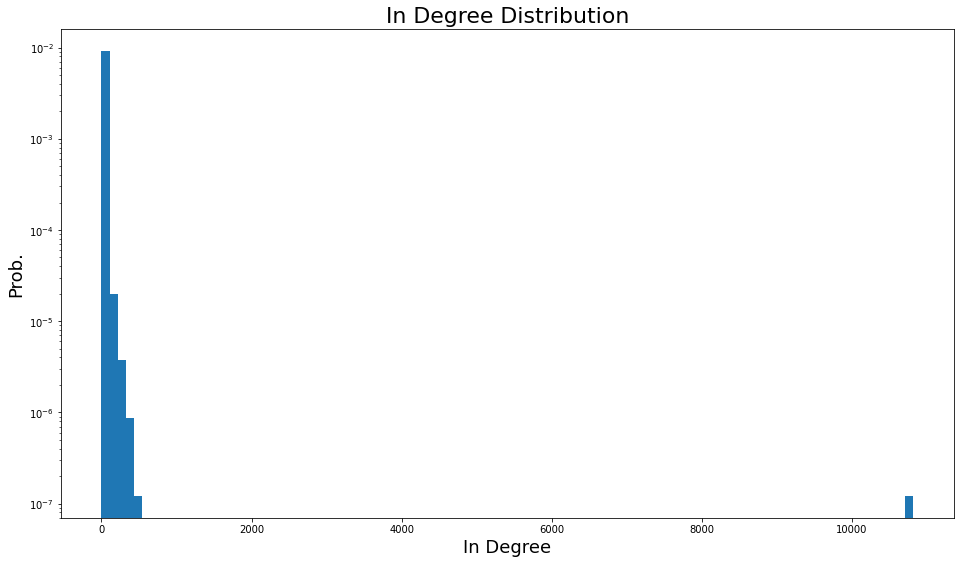

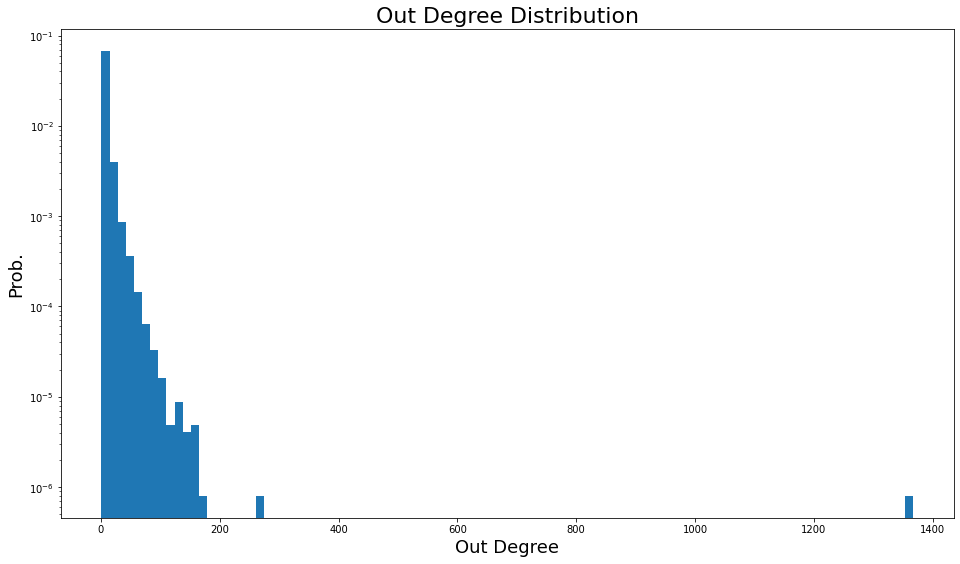

In [20]:
G.plot_degree_distr()

## Question 2

## Breadth-First-Search (BFS) within distance d
Given a page **v** and the number of clicks **d** we have to return the set of all pages that a user can reach within d clicks. This problem is a simple Breadth-First-Search where we stop the algorithm when we find all the nodes ad distance d from the origin.

Starting from the node **95** within **10** clicks we can reach 60531 different nodes,here we return their label and their distance from the orign.

In [21]:
v = 95
d = 10
G.bfs(v, max_distance=d)

,Names,Distance
Node,,
95,This Way (Hana Pestle album),0
1185516,Marty O'Brien,1
150451,22nd Century Lifestyle,2
1062563,Lindsay Lohan,2
1178930,Marilyn Manson,2
...,...,...
1046428,Kitty (1929 film),10
1006500,Derek Possee,10
77027,Albert Hoskins,10


In [22]:
v = 235101
d = 10
G.bfs(v)

The node 235101 is not present in the graph!


The node **235100** has no outgoing edges so it can reach only itself.

In [23]:
v = 235100
d = math.inf
G.bfs(v)

,Names,Distance
Node,,
235100,James Pierpont (Yale founder),0


## Question 3
Given in input:
* A category C
* A set of pages in C, p = {p1, ..., pn}

returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

As metrics of centrality, we adopted the Degree centrality for directed networks, with:

$centrality_{indegree}^{v}=\frac{deg_{indegree}^{v}}{|N|-1}$

where:

$centrality_{indegree}^{v}$ is the centrality-score of a node $v$

$deg_{indegree}^{v}$ is the IN-degree of node $v$

$|N|$ is the number of nodes of the graph $G$

Due to the problem is computational expensive we run it first for a small random number of pages than fore more pages,all of them are taken from a category chosen at random from all category we have.

First example:

In [24]:
C = G.nodes.Category.sample().iloc[0]
max_pages = 3
n_pages = np.random.randint(1, max_pages)
p = set(G.nodes[G.nodes.Category == C].sample(n_pages, replace=True).index.tolist())
min_click = G.min_clicks(C, p)
if min_click is not None:
    print(f"To reach the pages {p}, belonging to the category {C}, starting from the category's most central article it requires at least {min_click} clicks.")
else:
    print(f"It's not possible to reach all the pages {p}, belonging to the category {C}, starting from the category's most central article.")

To reach the pages {1163207}, belonging to the category American_television_actors, starting from the category's most central article it requires at least 4 clicks.


Second example

In [25]:
C = G.nodes.Category.sample().iloc[0]
max_pages = 20
n_pages = np.random.randint(5, max_pages)
p = set(G.nodes[G.nodes.Category == C].sample(n_pages, replace=True).index.tolist())
min_click = G.min_clicks(C, p)
if min_click is not None:
    print(f'To reach the pages {p}, belonging to the category {C}, it requires at least {min_click} clicks.')
else:
    print(f"It's not possible to reach all the pages {p}, belonging to the category {C}.")

Not possible!
It's not possible to reach all the pages {1042304, 1247200, 1446588, 1042635, 1056908, 1053004, 1551598, 1056495, 251989, 1067254, 1063352, 1056505, 1376764, 1063709, 1556223}, belonging to the category English-language_films.


## Question 4
Given in input two categories: $C1$ and $C2$, we get the subgraph induced by all the articles in the two categories.
* Let v and u two arbitrary pages in the subgraph return  minimum set of hyperlinks one can remove to disconnect u and v.

The ***induced subgraph*** of a graph is another graph, formed from a subset of the vertices of the graph and all of the edges connecting pairs of vertices in that subset.

In our particular case the subset of nodes is the one made by the articles belonging to the two category $C1$ and $C2$ that we choose at random from all the categories.

Then chosen $v$ and $u$ the minimum number of links that we have to remove to disconnect them is the same of calculating the number of edges of the min cut which divide the graph in two partitions $P1$ and $P2$ such that $ v \in P1$ and $ u \in P2$.


To find the min cut we used the **Karger's Algorithm** which is a randomized algorithm that gives a good approximation for the cardinality of the min-cut.The algorithm follows principally four steps:

1. Choose an edge uniformly at random
2. Contract the edge
3. Repeat steps 1 and 2 until two nodes are left
4. Return the cut defined by the nodes and the esges left

Since the algorithm is a randomized algorithm it may return the wrong answer. So the number of times we have to repeat it in orded to have a $Probability(Fail) \le {1\over n}$ ,where $n$ is the number of edges, is $n^2ln(n)$.

In [26]:
C1, C2 = np.random.choice(G.nodes.Category.unique(), 2)
print(f"The minimum number of hyperlinks we have to remove in order to disconnect two random nodes, belonging to the categories {C1} or {C2}, is {G.min_link_to_disconnect(C1, C2)}")

The minimum number of hyperlinks we have to remove in order to disconnect two random nodes, belonging to the categories Association_football_forwards or Debut_albums, is 0


Unfortunately most of the categories are already disconnected so Karger's algorithm returns 0.

## Question 5
Given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as

* distance(C0, Ci) = median(ShortestPath(C0, Ci))

where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.

In [27]:
C = G.nodes.Category.sample().iloc[0]
C

'Association_football_midfielders'

In [29]:
G.distances_from_category(C)

100%|██████████████████████████████████████████████████████████████████████████████| 2763/2763 [07:50<00:00,  5.88it/s]


,C0,Ci,Dist
0,Association_football_midfielders,Debut_albums,inf
9,Association_football_midfielders,Year_of_death_missing,inf
17,Association_football_midfielders,Indian_films,inf
15,Association_football_midfielders,English_footballers,inf
14,Association_football_midfielders,The_Football_League_players,inf
13,Association_football_midfielders,Association_football_forwards,inf
12,Association_football_midfielders,Association_football_defenders,inf
11,Association_football_midfielders,Year_of_birth_missing,inf
19,Association_football_midfielders,Major_League_Baseball_pitchers,inf
8,Association_football_midfielders,Asteroids_named_for_people,inf


In [30]:
G.distances_from_category(C, condider_inf_distance=False)

100%|██████████████████████████████████████████████████████████████████████████████| 2763/2763 [06:19<00:00,  7.27it/s]


,C0,Ci,Dist
18,Association_football_midfielders,Rivers_of_Romania,10.0
17,Association_football_midfielders,Indian_films,10.0
7,Association_football_midfielders,Main_Belt_asteroids,10.0
19,Association_football_midfielders,Major_League_Baseball_pitchers,9.0
8,Association_football_midfielders,Asteroids_named_for_people,9.0
16,Association_football_midfielders,Members_of_the_United_Kingdom_Parliament_for_E...,8.0
11,Association_football_midfielders,Year_of_birth_missing,8.0
9,Association_football_midfielders,Year_of_death_missing,8.0
0,Association_football_midfielders,Debut_albums,8.0
6,Association_football_midfielders,Harvard_University_alumni,8.0


## Question 6

## PageRank algorithm
The PageRank algorithm outputs a probability distribution used to represent the likelihood that a person randomly clicking on links will arrive at any particular page. Hence, a category with a PageRank of 0.5 means there is a 50% chance that a person clicking on a random link will be directed to a node of that category.

Here we use the model of **random surfer**, the model attempts to predict the chance that a random internet surfer will arrive at a page by either clicking a link or by accessing the site directly, for example by directly entering the website's URL in the address bar.

The probability, at any step, that the person follows the links in the page is a damping factor $d$ ,consequently the probability to move to a random page searching it in the adress bar is $1-d$.

The **random surfer model**  can be understood as a Markov chain in which the states are pages, and the transitions are the links between pages – all of which are all equally probable.

Here we can see that doesn't matter where the **surfer** starts because after a large number of steps it converge to the same distibution of page probability.

In [31]:
def pagerank(M, num_iterations: int = 100, d: float = 0.85):
    """
    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    
    v = np.random.rand(1, N)
    v = v / np.sum(v)
    M_hat = (d * M + (1 - d) / N)
    for i in range(num_iterations):
        v = v @ M_hat
    return v

In [32]:
G.category_rank()

,Category,PageRank
4,American_film_actors,0.144084
1,English-language_films,0.097170
7,Main_Belt_asteroids,0.083602
5,American_television_actors,0.074745
15,The_Football_League_players,0.067799
16,English_footballers,0.066966
17,Members_of_the_United_Kingdom_Parliament_for_E...,0.060846
2,American_films,0.056356
19,Rivers_of_Romania,0.048080
20,Major_League_Baseball_pitchers,0.045978


# EXTRA

We decided to implement some of the exercises also by using the **NetworkX** library, in order to perform the homework more completely.

#### Initialization

Import libraries:

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

Import the data 'wikigraph_reduced.csv':

In [6]:
path='./data/wikigraph_reduced.csv' #insert your own path of the file 'wikigraph_reduced.csv'
dataset=pd.read_csv(path, sep='\t')
dataset.rename(columns={'Unnamed: 0':'old_index'}, inplace=True)

# RQ. 1

### Creation of the graph $G=(V, E)$, where $V$ is the set of articles and $E$ the hyperlinks among them

In [7]:
G = nx.DiGraph()
for i in range(0, len(dataset)):
    G.add_node(dataset.iloc[i][1])
    G.add_node(dataset.iloc[i][2])
    G.add_edge(dataset.iloc[i][1],dataset.iloc[i][2])

### Is the graph directed?

Yes! We are working on a directed graph $G=(V,E)$, because our nodes $V$ (***articles***) are connected together by edges $E$ (***hyperlinks***) directed from one vertex to another.

### How many articles are we considering?

Since each node corresponds to an article, we can count the number of articles just counting the number of nodes of our Graph $G$:

In [66]:
num_V=G.number_of_nodes()
num_V

98343

So we're considering **98343** articles.

### How many hyperlinks between pages exist?

Since each edge corresponds to an hyperlink between 2 articles, we can count the number of hyperlinks just counting the number of edges of our Graph  $G$ :

In [64]:
num_E=G.number_of_edges()
num_E

483094

So there are **483094** hyperlinks.

### Average number of links in an arbitrary page

The average degree of our directed graph is: $(k^{in})=(k^{out})=\frac{1}{N} \sum_{i=1}^{N}k_{i}^{in}=\frac{1}{N} \sum_{i=1}^{N}k_{i}^{out}=\frac{totalnumberofhyperlinks}{totalnumberofarticles} $

In [96]:
avg_deg=num_E/num_V
avg_deg

4.912337431235573

In fact:

In [97]:
tot_in_deg=0
for i in list(G.nodes()):
    tot_in_deg+=G.in_degree(i)
    
tot_out_deg=0
for i in list(G.nodes()):
    tot_out_deg+=G.out_degree(i)
    
print('The total IN-degree of the graph is: ', tot_in_deg)
print('The total OUT-degree of the graph is: ', tot_out_deg)

The total IN-degree of the graph is:  483094
The total OUT-degree of the graph is:  483094


### Density of our Graph

The density of the graph $G$ measures how many hyperlinks are in set $E$ compared to the maximum possible number of hyperlinks between articles in set $V$

The density of our directed graph is: $D= \frac{|E|}{2\binom{|V|}{2}} = \frac{|E|}{|V|(|V|-1)} $

In [68]:
density=num_E/(num_V*(num_V-1))
density

4.9951571365597335e-05

### Check if our graph is Dense or Sparse

To see if our graph is sparse or dense, we consider that the density of a sparse graph is in lower range of the density’s codomain ($ 0 \leqslant  density < \frac {1} {2}$); the density of a dense graph is in the higher range of its codomain ($ \frac {1} {2} < density \leqslant  1$), so:

In [76]:
if density>=0 and density<(0.5):
    print('Our graph is SPARSE')
else:
    print('Our graph is DENSE')

Our graph is SPARSE


So it means that our dense graph the number of edges is NOT close to the maximal number of edges, in fact:

In [77]:
max_n_edges=num_V*(num_V-1)
max_n_edges

9671247306

The maximum number of edges is 9671247306, but we've only 483094 edges, far from the maximum.

### Nodes' degree distribution

In [8]:
def in_degree_distribution(G):
    in_degree = dict(G.in_degree())
    degrees=[in_degree.get(k,0) for k in G.nodes()]
    max_deg=max(degrees)+1
    frequency= [ 0 for d in range(max_deg) ]
    for deg in degrees:
        frequency[deg] += 1
    return frequency

def out_degree_distribution(G):
    out_degree = dict(G.out_degree())
    degrees=[out_degree.get(k,0) for k in G.nodes()]
    max_deg=max(degrees)+1
    frequency= [ 0 for d in range(max_deg) ]
    for deg in degrees:
        frequency[deg] += 1
    return frequency
    

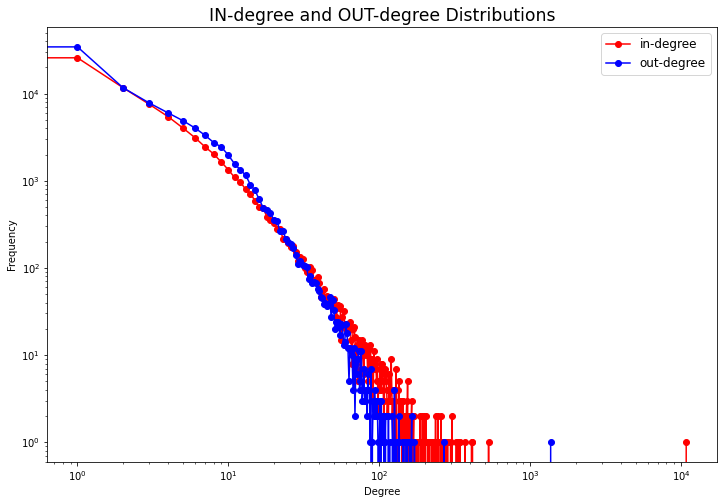

In [9]:
in_degrees = in_degree_distribution(G)
out_degrees = out_degree_distribution(G)
degrees = range(len(out_degrees))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degrees)), in_degrees, 'ro-', label='in-degree') 
plt.loglog(range(len(out_degrees)), out_degrees, 'bo-', label='out-degree')
plt.legend(loc="upper right",fontsize='large')
plt.title('IN-degree and OUT-degree Distributions', fontsize='xx-large')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

# RQ.2

Our function is called **all_possible_nodes(**graph, source, k**)**; it will return the set of all pages that a user can reach within ***k*** clicks:

In [ ]:
def all_possible_nodes(graph, source, k):
    
    def find_all_paths(graph, start, k,i=0, path=[], node_exists=True):
        if node_exists:
            path = path + [start]
            if k==0 or i>=k:
                return [path]
            paths = []
            for node in graph[start]:
                if node not in path:
                    newpaths = find_all_paths(graph, node, k,i+1, path)
                    for newpath in newpaths:
                        paths.append(newpath)
            return paths
        else:
            return "This source node does not exist in the graph"
    
    if any([node for node in G.nodes() if node== source]):
    
        poss=set()
        for path in find_all_paths(graph, source, k):
            for elem in path:
                poss.add(elem)
        return poss
    else:
        return find_all_paths(graph, source, k, node_exists=False)

Now let's try our function, for example searching all possible nodes that we can reach from node ***108*** within ***1*** click:

In [143]:
all_possible_nodes(G,108, 1)

{108, 1059989, 1062426, 1161925}

Now  let's try starting from node ***108*** within ***2*** clicks:

In [13]:
np.array(all_possible_nodes(G,108, 2))

array({1664010, 689163, 1060238, 1015568, 1066131, 1059988, 1059989, 1060884, 1062426, 1163419, 1763995, 1056157, 1062557, 1032867, 147492, 1032868, 41891, 418476, 1164977, 1059505, 137144, 1162809, 1054394, 1165884, 688704, 1068100, 1161925, 1059782, 1632839, 628169, 1055563, 155981, 1132626, 422996, 635998, 688741, 1141095, 1015403, 108, 1061228, 1166447, 1054071},
      dtype=object)

Another example: return all possible nodes that we can reach from node ***1032868*** within ***5*** clicks
(in this case, because of the huge length of the result, we show just the first 150 elements of the output):

In [20]:
np.array(list(all_possible_nodes(G,1032868, 5))[:150])

array([ 655377,  655392, 1048636, 1048637, 1048638, 1048648, 1048654,
       1048658, 1179733,  655451,  655453, 1048674, 1048686,  655471,
       1048700, 1048703,     134, 1179783, 1048710, 1048713, 1179786,
       1048715,  393356, 1048720,  393360, 1048722, 1048723, 1048721,
        393366,  393367,  393368,     153,  393370, 1048731,  393372,
        393371, 1048735, 1048736, 1048741, 1048745, 1048749,     174,
           173, 1048777, 1179850, 1048787, 1048792, 1048795, 1179870,
       1048801, 1179875, 1048806, 1048810, 1179883, 1048811, 1048812,
       1048816, 1048817, 1048819, 1048820, 1048821, 1048822,  393466,
       1048829, 1048830, 1048831, 1048835, 1048836, 1048839, 1048840,
       1048844, 1048846, 1179919, 1048850, 1179925, 1048854, 1048855,
       1048856, 1048857, 1048864, 1048866, 1048868, 1179950, 1048880,
       1048881, 1048883, 1048884, 1048885, 1048886,  573196, 1048888,
       1048890,  573197, 1048895, 1048897, 1048900, 1048902, 1048905,
       1048906, 1048

In the end, let's try our function starting from **19**, a node that doesn't exists in our graph:

In [151]:
all_possible_nodes(G,19, 10)

'This source node does not exist in the graph'

# RQ. 3

Our function **min_len_to_reach_p(**C,p,G**)** is a function that takes in input:
- C : the name of the category
- $p$={ $p_{1}, p_{2}, ... , p_{n}$} : a set of pages in C 

and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.


As before, as metrics of centrality we adopted the ***Degree centrality*** for directed networks.

In [ ]:
def min_len_to_reach_p(C,p,G):
    global _path_
    
    #search the required category and its respective pages
    path_wiki_topcats='' #put here your path of the file "wiki-topcats-categories.txt" 
    f=open(path_wiki_topcats, 'r')
    for line in f:
        category=re.search(r'\:(.*)\; ', line).group(1)
        if C==category.strip():
            pages=list(map(int,(re.search(r';(.*)', line).group(1)).strip().split()))
            break
    
        
    #create a dictionary d where keys are the nodes of the category, and the values corresponds
    #to the respective centrality-score of the node
    d={}
    num_V=G.number_of_nodes()
    for node in pages:
        
        if node not in G.nodes():
            pass
        else:
            centrality=G.in_degree(node)/(num_V-1)
            d[node]=centrality
            
    if len(d.keys())==0:
        return 'Not possible'
    
    #let's find the most central node:
    max_centr=0
    max_node=0
    for key, value in d.items():
        
        if value>=max_centr:
            max_centr=value
            max_node=key
            
    
    #find, if exists, the shortest path that reach all pages in p
    shortest_paths=nx.shortest_path(G,source=max_node)
    shortest=[]
    sh_len=0
    for key in shortest_paths.keys():
        if key in pages:
            copy=list(p)
            if max_node in copy:
                copy.remove(max_node)
            for i in shortest_paths[key]:
                if i in copy:
                    copy.remove(i)
            if len(copy)==0 and len(shortest_paths[key])>sh_len:
                shortest=shortest_paths[key]
                sh_len=len(shortest_paths[key])
    if len(shortest)==0:
        return 'Not Possible'
    else:
        _path_=shortest
        return sh_len
    

Let's try some example:

In [117]:
min_len_to_reach_p('Expatriate_footballers_in_Mexico',{27301,89867}, G)

6

and the respective shortest path of lenght equal to 6 is:

In [118]:
_path_

[1358669, 89867, 76811, 27568, 27565, 27301]

where the first node (1358669) is the most central node of the Category 'Expatriate_footballers_in_Mexico'; note that in this path all nodes belonging from p (27301,89867) are reached.

Some other examples are following:

In [147]:
min_len_to_reach_p('People_from_Crdoba_Province_(Argentina)',{88212,1358227,88509}, G)

10

and the respective path, where all nodes in p={88212,1358227,88509} are reached, is:

In [148]:
_path_

[84267, 89701, 88859, 88863, 88509, 88667, 88212, 88512, 1642304, 1358227]

What if not all the pages in p are reachable from v?

In [149]:
min_len_to_reach_p('People_from_Crdoba_Province_(Argentina)',{88212,88509,1642615}, G)

'Not Possible'